In [1]:
import helper
import pandas as pd
from utils import *

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from IPython.display import Image

In [2]:
df = pd.read_csv('dataset_MRK_prediction.csv')
df = df.drop(['Date' ,'Unnamed: 0'], axis=1)
df

,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,...,GSK,LLY,NVS,NYSE,NASDAQ,FT3,FT6,FT9,ARIMA,Close_lead1
0,31.011450,14227229,30.050436,29.200291,29.514006,29.867322,0.353316,0.835852,30.871996,27.528586,...,20.441219,22.546120,26.214659,6671.140137,2017.979980,55.454947,50.337802,47.947327,31.011450,31.440840
1,31.440840,20081566,30.318975,29.299346,29.688906,30.115697,0.426791,0.963549,31.226444,27.372247,...,20.290920,22.639698,26.532934,6697.220215,2024.229980,55.359252,50.140845,47.659130,31.440840,31.183207
2,31.183207,10438080,30.564340,29.420211,29.822316,30.283528,0.461212,1.026446,31.473102,27.367319,...,20.280550,22.492653,26.608170,6687.939941,2024.430054,55.263482,49.944470,47.372320,31.183207,31.364504
3,31.364504,10302154,30.858779,29.556525,29.957940,30.452906,0.494965,1.086420,31.729366,27.383684,...,20.513784,22.800129,26.984316,6722.310059,2027.729980,55.167638,49.748691,47.086936,31.364504,30.839695
4,30.839695,12640452,30.973283,29.664667,30.034423,30.513340,0.478916,1.094567,31.853801,27.475534,...,20.285738,22.459227,26.857002,6709.040039,2028.770020,55.071723,49.553518,46.803017,30.839695,30.944656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2712,78.301529,13675457,75.931026,74.702836,75.305196,75.725497,0.420300,1.705192,78.113220,71.292452,...,38.856968,148.141144,82.393753,12302.190430,9682.910156,57.910147,55.622779,55.790021,76.887436,77.814888
2713,77.814888,9292930,76.515814,74.863687,75.491099,76.046941,0.555842,1.816324,78.496336,71.231038,...,38.423382,146.373550,81.836136,12286.980469,9615.809570,57.817099,55.415062,55.480641,78.191500,78.492363
2714,78.492363,10413347,77.157852,75.097238,75.713415,76.423160,0.709745,1.857931,78.813100,71.381377,...,38.469505,144.916718,82.576424,12641.440430,9814.080078,57.723926,55.207594,55.171523,77.972240,79.103050
2715,79.103050,9956838,77.684024,75.428935,75.964499,76.835451,0.870952,1.960788,79.350511,71.507360,...,39.087601,144.916718,82.364914,12836.599609,9924.750000,57.630627,55.000389,54.862711,78.309688,78.492363


In [3]:
target = "Close_lead1"
features = list(df.columns.difference(["Close", 'Close_lead1']))
features

['12ema',
 '20sd',
 '26ema',
 'AMGN',
 'ARIMA',
 'BMY',
 'FT3',
 'FT6',
 'FT9',
 'GSK',
 'JNJ',
 'LLY',
 'MACD',
 'NASDAQ',
 'NVS',
 'NYSE',
 'PFE',
 'SNP',
 'SNY',
 'VTRS',
 'VZ',
 'Volume',
 'ema',
 'log_momentum',
 'lower_band',
 'ma21',
 'ma7',
 'momentum',
 'neg',
 'neu',
 'pos',
 'upper_band']

In [4]:
size = int(len(df) * 0.67)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

In [5]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [6]:
df_train

,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,...,GSK,LLY,NVS,NYSE,NASDAQ,FT3,FT6,FT9,ARIMA,Close_lead1
0,-1.367412,0.009724,-1.467094,-1.548950,-1.517050,-1.485346,0.483927,0.004259,-1.502313,-1.585985,...,-1.542295,-1.223130,-1.526392,-1.633607,-1.505769,1.116638,0.661488,0.417660,-1.367501,-1.323510
1,-1.322237,0.802780,-1.438767,-1.538476,-1.498487,-1.459093,0.631273,0.298574,-1.465953,-1.602907,...,-1.573396,-1.217681,-1.504030,-1.615623,-1.499763,1.106391,0.640008,0.386462,-1.322322,-1.350606
2,-1.349342,-0.503571,-1.412885,-1.525696,-1.484328,-1.441353,0.700299,0.443539,-1.440650,-1.603441,...,-1.575542,-1.226244,-1.498744,-1.622022,-1.499571,1.096136,0.618591,0.355414,-1.349429,-1.331539
3,-1.330268,-0.521984,-1.381826,-1.511282,-1.469934,-1.423450,0.767988,0.581768,-1.414362,-1.601669,...,-1.527280,-1.208338,-1.472316,-1.598321,-1.496400,1.085874,0.597239,0.324520,-1.330354,-1.386733
4,-1.385481,-0.205228,-1.369748,-1.499847,-1.461816,-1.417062,0.735804,0.600543,-1.401597,-1.591727,...,-1.574469,-1.228190,-1.481261,-1.607472,-1.495401,1.075603,0.575953,0.293785,-1.385573,-1.375694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1816,1.444453,-0.790046,1.325599,1.490326,1.499290,1.406282,-1.648395,1.098484,1.543603,1.422397,...,0.460208,1.292560,0.385506,1.027732,1.545663,0.918170,1.607433,1.609781,1.392039,1.810552
1817,1.812877,2.036372,1.404108,1.501137,1.525281,1.471589,-0.900462,1.532956,1.592766,1.392654,...,0.660840,1.518595,0.544018,1.105551,1.600993,0.918721,1.612203,1.615176,1.438596,1.888829
1818,1.891180,0.618294,1.485493,1.516992,1.555199,1.538952,-0.187707,2.019262,1.651437,1.363207,...,0.581227,1.542545,0.532433,1.133133,1.560375,0.919288,1.616942,1.620559,1.794709,1.787471
1819,1.789788,0.078450,1.558970,1.523911,1.575324,1.580280,0.216125,2.256141,1.679235,1.348040,...,0.468170,1.507662,0.501889,1.111639,1.587579,0.919870,1.621649,1.625928,1.875531,1.745322


In [7]:
from Factory import SequenceDataset

In [8]:
torch.manual_seed(101)

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 32])
Target shape: torch.Size([1])


In [9]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

In [10]:
from Factory import ShallowRegressionLSTM

In [11]:
learning_rate = 0.0001
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
classical_loss_train = []
classical_loss_test = []
print("Untrained test\n--------")
test_loss = test_model(test_loader, model, loss_function)
print()
classical_loss_test.append(test_loss)

for ix_epoch in range(20):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    print()
    classical_loss_train.append(train_loss)
    classical_loss_test.append(test_loss)

Untrained test
--------
Test loss: 8.610089948145442

Epoch 0
---------
Train loss: 0.26532624034683294
Test loss: 2.6338868914927716

Epoch 1
---------
Train loss: 0.03469269386400278
Test loss: 2.006117905782167

Epoch 2
---------
Train loss: 0.017827948561038115
Test loss: 1.7888867414367908

Epoch 3
---------
Train loss: 0.011995089877132726
Test loss: 1.614061121683431

Epoch 4
---------
Train loss: 0.00945538427224977
Test loss: 1.5142774181375414

Epoch 5
---------
Train loss: 0.008296079606135773
Test loss: 1.4813240397110907

Epoch 6
---------
Train loss: 0.007585738064515137
Test loss: 1.417895434040816

Epoch 7
---------
Train loss: 0.007150696812582197
Test loss: 1.4101453756885545

Epoch 8
---------
Train loss: 0.00669386339186409
Test loss: 1.3786947978804664

Epoch 9
---------
Train loss: 0.0062523534248405035
Test loss: 1.3218226207512411

Epoch 10
---------
Train loss: 0.0060510072572731695
Test loss: 1.304483597021529

Epoch 11
---------
Train loss: 0.0057308201831493

In [13]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [14]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

      Close_lead1  Model forecast
0       31.440840       30.972647
1       31.183207       31.023441
2       31.364504       31.186171
3       30.839695       31.310280
4       30.944656       31.142120
...           ...             ...
2712    77.814888       62.234993
2713    78.492363       62.333565
2714    79.103050       62.482479
2715    78.492363       62.608040
2716    78.024811       62.559753

[2718 rows x 2 columns]


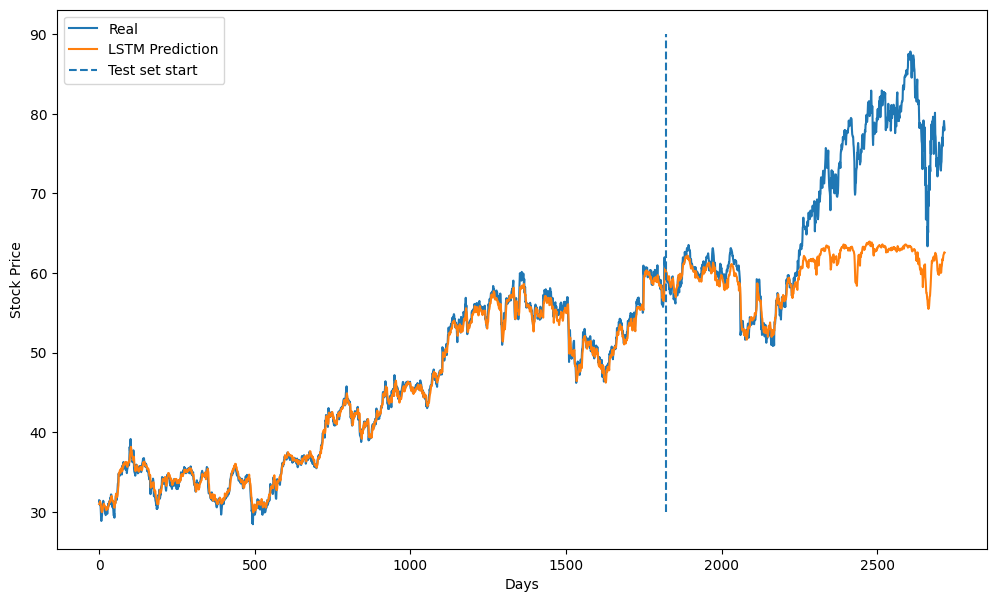

In [15]:
plt.figure(figsize=(12, 7))
plt.plot(range(2718), df_out["Close_lead1"], label = "Real")
plt.plot(range(2718), df_out["Model forecast"], label = "LSTM Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 30, ymax = 90, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

In [16]:
from Factory import QShallowRegressionLSTM

In [138]:
learning_rate = 0.05
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)


In [139]:
quantum_loss_train = []
quantum_loss_test = []
print("Untrained test\n--------")
start = time.time()
test_loss = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(20):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

Untrained test
--------


IndexError: list index out of range